In [80]:
import requests
from bs4 import BeautifulSoup
import pickle
import numpy as np
import quandl
import pandas as pd

from IPython.display import clear_output

In [316]:
resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(resp.text, 'html5lib')
table = soup.find('table', {'class': 'wikitable sortable'})

sp500_dict = {}
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    if '.' in ticker:
        ticker = ticker.replace('.', '_')
    company_name = row.findAll('td')[1].text
    gics_sector = row.findAll('td')[3].text
    gics_subindustry = row.findAll('td')[4].text
    cik = row.findAll('td')[7].text
    
    sp500_dict[ticker] = {'company_name': company_name, \
                          'cik': cik, \
                          'gics': {'sector': gics_sector, \
                                   'sub_industry': gics_subindustry}}

In [447]:
sectors = list(set([val['gics']['sector'] for key,val in sp500_dict.items()]))

num_companies_in_each_sector = {}

tickers_grouped_by_industry = []
for sector in sectors:
    companies_in_sector = [key for key,val in sp500_dict.items() if val['gics']['sector']==sector]
    tickers_grouped_by_industry += companies_in_sector
    
    num_companies_in_each_sector[sector] = len(companies_in_sector)

In [451]:
subindustries = list(set([val['gics']['sub_industry'] for key,val in sp500_dict.items()]))

num_companies_in_each_subindustry = {}

tickers_grouped_by_subindustry = []
for subindustry in subindustries:
    companies_in_subindustry = [key for key,val in sp500_dict.items() if val['gics']['sub_industry']==subindustry]
    tickers_grouped_by_subindustry += companies_in_subindustry
    
    num_companies_in_each_subindustry[subindustry] = len(companies_in_subindustry)

In [32]:
# https://www.quandl.com/tools/python

quandl.ApiConfig.api_key = "cTx8qMCxydUgAKGszVrf"

In [79]:
# get all historical closing prices for all stocks in S&P500
mydata = quandl.get('WIKI/'+tickers_grouped_by_industry[0], column_index=4)
mydata.columns=[tickers_grouped_by_industry[0]]
for idx,ticker in enumerate(tickers_grouped_by_industry[1:]):
    clear_output(wait=True)
    print('%0.05f'%((idx+1)/len(tickers_grouped_by_industry)))
    
    mydata[ticker] = quandl.get('WIKI/'+ticker, column_index=4)['Close']
np.save('closing_price_data', mydata)

0.99802


In [110]:
# only interested in 2005-10, contains one stock market crash of 2008
data_05_10 = mydata.loc['2005-01-03':'2010-12-31']

# delete tickers for which all prices are null
del_cols = data_05_10.columns[data_05_10.isnull().sum()==data_05_10.shape[0]]
for col in del_cols:
    data_05_10 = data_05_10.drop(col, 1)

# fill nan prices with first available price
data_05_10 = data_05_10.fillna(method='bfill')

In [622]:
def get_price_ret(df,col1):
    p_t_minus_1 = df[col1].values[:-1]
    p_t = df[col1].values[1:]
    return np.log(p_t/p_t_minus_1)

In [625]:
dfdf=pd.DataFrame()
for ticker in tickers_grouped_by_industry:
    dfdf[ticker]=get_price_ret(data_05_10,ticker)


In [155]:
def get_cross_correlation(df, col1, col2):
    mean1 = np.mean(df[col1].values)
    mean2 = np.mean(df[col2].values)

    a = 0.0
    b = 0.0
    c = 0.0
    for idx,val in enumerate(df[col1].values):
        a += (val-mean1)*(df[col2].values[idx]-mean2)
        b += (val-mean1)**2
        c += (df[col2].values[idx]-mean2)**2
    corr = a / ((b**0.5)*(c**0.5))
    
    return corr

In [662]:
a = 0.0
b = 0.0
c = 0.0
l1=[1,2,5]
l2=[11,12,20]
mean1 = np.mean(l1)
mean2 = np.mean(l2)
for idx,val in enumerate(l1):
    a += (val-mean1)*(l2[idx]-mean2)
    b += (val-mean1)**2
    c += (l2[idx]-mean2)**2
corr = a / ((b**0.5)*(c**0.5))
corr

0.99007189657082295

In [578]:
corr_mat = np.zeros((len(data_05_10.columns), len(data_05_10.columns)))

for idx,col1 in enumerate(tickers_grouped_by_subindustry):
    clear_output(wait=True)
    print('%0.05f'%((idx+1)/len(tickers_grouped_by_subindustry)))
    for idx1,col2 in enumerate(tickers_grouped_by_subindustry[idx:]):
        corr_mat[idx,idx+idx1] = ts.coint(data_05_10[col1].values,data_05_10[col2].values)[1]#get_cross_correlation(data_05_10, col1, col2)
        corr_mat[idx+idx1,idx] = corr_mat[idx,idx+idx1]
#np.save('corr_mat_by_subindustry', corr_mat)

1.00000


In [632]:
corr_mat = np.zeros((len(dfdf.columns), len(dfdf.columns)))

for idx,col1 in enumerate(tickers_grouped_by_subindustry):
    clear_output(wait=True)
    print('%0.05f'%((idx+1)/len(tickers_grouped_by_subindustry)))
    for idx1,col2 in enumerate(tickers_grouped_by_subindustry[idx:]):
        corr_mat[idx,idx+idx1] = get_cross_correlation(dfdf, col1, col2)
        corr_mat[idx+idx1,idx] = corr_mat[idx,idx+idx1]
np.save('corr_mat_by_subindustry_return', corr_mat)

1.00000


In [616]:
corr_mat = np.zeros((len(data_05_10.columns), len(data_05_10.columns)))

for idx,col1 in enumerate(tickers_grouped_by_subindustry):
    clear_output(wait=True)
    print('%0.05f'%((idx+1)/len(tickers_grouped_by_subindustry)))
    for idx1,col2 in enumerate(tickers_grouped_by_subindustry[idx:]):
        #x1=data_05_10[col1].values.reshape(-1, 1)
        #y1=data_05_10[col2].values.reshape(-1, 1)
        #dist, cost, acc, path = dtw(x1, y1, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
        x1=data_05_10[col1].values
        y1=data_05_10[col2].values
        dist, path = fastdtw(x1, y1, dist=euclidean)
        corr_mat[idx,idx+idx1] = dist#ts.coint(,)[1]#get_cross_correlation(data_05_10, col1, col2)
        corr_mat[idx+idx1,idx] = corr_mat[idx,idx+idx1]
#np.save('corr_mat_by_subindustry', corr_mat)

0.00217


KeyboardInterrupt: 

In [ ]:
np.save('dtw_mat_by_subindustry', corr_mat)

In [613]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

x1=data_05_10['APD']
y1=data_05_10['ALB']
distance, path = fastdtw(x1, y1, dist=euclidean)
print(distance)

29187.65000000002


In [630]:
corr_mat

array([[ 1.        ,  0.56615184,  0.63006439, ...,  0.53361703,
         0.48356182,  0.63152887],
       [ 0.56615184,  1.        ,  0.51941946, ...,  0.44099687,
         0.38976094,  0.53231976],
       [ 0.63006439,  0.51941946,  1.        , ...,  0.43751295,
         0.45599198,  0.56304762],
       ..., 
       [ 0.53361703,  0.44099687,  0.43751295, ...,  1.        ,
         0.47269301,  0.62350509],
       [ 0.48356182,  0.38976094,  0.45599198, ...,  0.47269301,
         1.        ,  0.61807066],
       [ 0.63152887,  0.53231976,  0.56304762, ...,  0.62350509,
         0.61807066,  1.        ]])

In [552]:
from scipy.stats import pearsonr

In [650]:
corr_mat=np.load('corr_mat_by_industry_return.npy')

for idx,i in enumerate(corr_mat):
    for idx1,j in enumerate(i):
        if j<0.9:
            corr_mat[idx1,idx]=0.0
            corr_mat[idx,idx1]=0.0

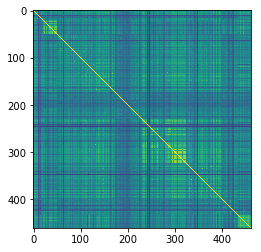

In [663]:
corr_mat=np.load('corr_mat_by_industry_return.npy')
plt.imshow(corr_mat)
plt.show()

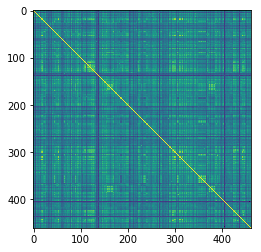

In [664]:
corr_mat=np.load('corr_mat_by_subindustry_return.npy')
plt.imshow(corr_mat)
plt.show()

In [654]:
np.correlate([1,2,3],[1,3])

array([ 7, 11])

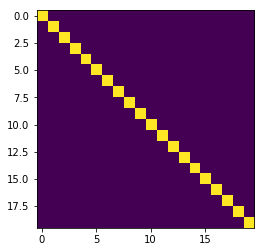

In [641]:
#corr_mat=np.load('corr_mat_by_sector.npy')
plt.imshow(corr_mat[250:270,250:270])
plt.show()

In [603]:
from dtw import dtw
x1=data_05_10['AMAT'].values.reshape(-1, 1)
y1=data_05_10['KLAC'].values.reshape(-1, 1)
dist, cost, acc, path = dtw(x1, y1, dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [563]:
import statsmodels.tsa.stattools as ts 
#result=ts.coint(x, y)

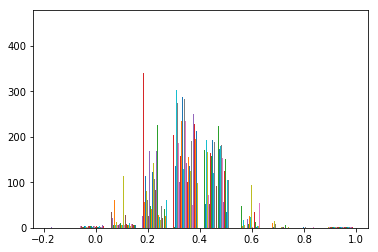

In [665]:
plt.hist(corr_mat)
plt.show()

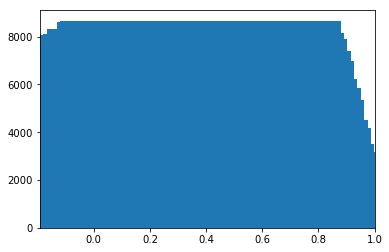

In [669]:
hist,bin_edges=np.histogram(corr_mat,bins=100)
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

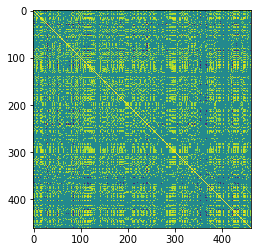

In [514]:
plt.imshow(corr_mat)
plt.show()

In [636]:
for idx,i in enumerate(corr_mat):
    for idx1,j in enumerate(i):
        if j<0.8:
            corr_mat[idx1,idx]=0.0
            corr_mat[idx,idx1]=0.0

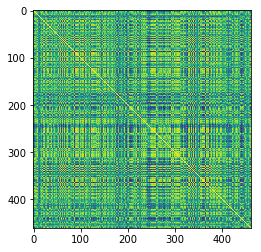

In [435]:
import matplotlib.pyplot as plt
plt.imshow(corr_mat)
plt.show()

In [363]:
for key,val in sp500_dict.items():
    if key not in data_05_10.columns:
        del sp500_dict[key]
        print(len(sp500_dict.keys()))

In [400]:
def get_corr_value(corr_mat, tickers, ticker1, ticker2):
    t = np.array(tickers)
    return corr_mat[np.argwhere(t==ticker1), np.argwhere(t==ticker2)][0][0]

In [ ]:
# heat map corr matrix, label companies too highlight sectors etc, order by industry